In [4]:
#!7z x processed.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 21719045 bytes (21 MiB)

Extracting archive: processed.zip
--
Path = processed.zip
Type = zip
Physical Size = 21719045

  0%     46% 1273 - processed/train/127082708/IMG_2957.jpg                                                   90% 2612 - processed/train/318900001/IMG_1891.jpg                                                  Everything is Ok

Folders: 183
Files: 2701
Size:       21679658
Compressed: 21719045


## Dataset

### Data exploration

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
from glob import glob
import os

In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
train_files = glob('./processed/train/*/*')
test_files = glob('./processed/test/*/*')
all_files = train_files + test_files
len(all_files)

2109

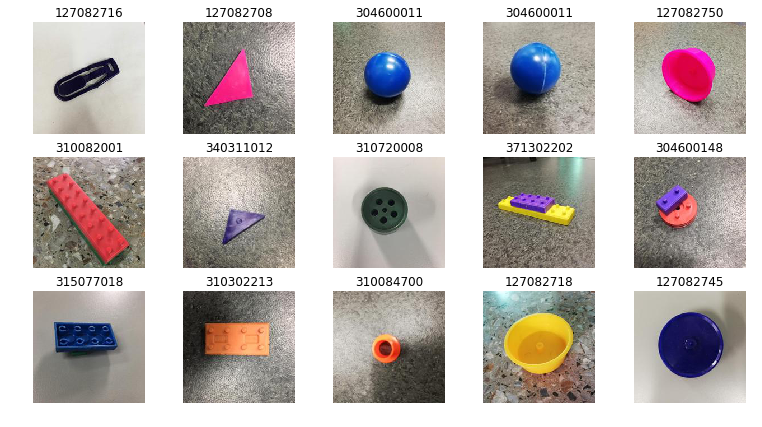

In [8]:
data = np.random.choice(train_files, 15)
labels = [os.path.basename(os.path.dirname(f)) for f in data]

plt.figure(figsize=(13, 7))
for k, (src, label) in enumerate(zip(data, labels)):
    im = PIL.Image.open(src).convert('RGB')
    plt.subplot(3, 5, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

### Data generators and data augmentation

#### Data generators

In [9]:
import tensorflow.keras.applications.inception_v3 as inception_v3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
TRAIN_DIR = './processed/train'
VALIDATION_DIR = './processed/dev'
TEST_DIR = './processed/test'


# Initialize data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=inception_v3.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=inception_v3.preprocess_input)

test_datagen = ImageDataGenerator(
    preprocessing_function=inception_v3.preprocess_input)


# Set directories and batch sizes for data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size = 1,
    class_mode='categorical', shuffle=False)

print(len(train_generator))
print(len(validation_generator))
print(len(test_generator))

Found 1595 images belonging to 60 classes.
Found 592 images belonging to 60 classes.
Found 514 images belonging to 60 classes.
50
19
514


#### Data augmentation examples

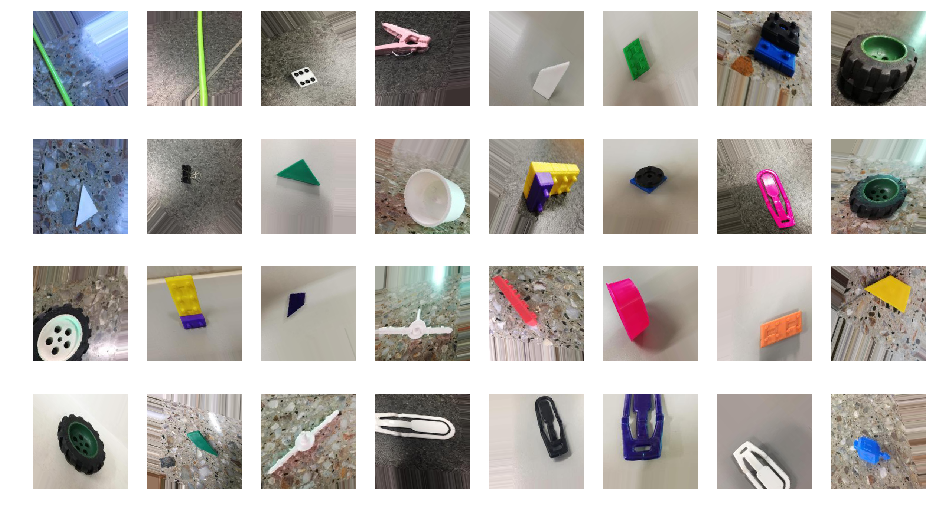

In [10]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(16, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Model

### Model definition

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau

CLASSES = 60
    
# setup model
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.Dropout(0.4)(x)
predictions = tf.keras.layers.Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


#for layer in base_model.layers:
#    layer.trainable = False
    
optimizer = tf.keras.optimizers.Adam(lr=0.001)
      
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

### Training

In [13]:
EPOCHS = 100
BATCH_SIZE = 32
MODEL_FILE = 'filename.model'

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.8,
                              patience=5, min_lr=0.0001)

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks = [reduce_lr])
  

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
50/50 [==============================] - 44s 890ms/step - loss: 3.2631 - acc: 0.2138 - top_k_categorical_accuracy: 0.4797 - val_loss: 11.2088 - val_acc: 0.0541 - val_top_k_categorical_accuracy: 0.2039
Epoch 2/100
50/50 [==============================] - 27s 545ms/step - loss: 1.8417 - acc: 0.4903 - top_k_categorical_accuracy: 0.8452 - val_loss: 9.6307 - val_acc: 0.1014 - val_top_k_categorical_accuracy: 0.2845
Epoch 3/100
50/50 [==============================] - 29s 577ms/step - loss: 1.2645 - acc: 0.6401 - top_k_categorical_accuracy: 0.9374 - val_loss: 6.9642 - val_acc: 0.1605 - val_top_k_categorical_accuracy: 0.4819
Epoch 4/100
50/50 [==============================] - 29s 576ms/step - loss: 1.1013 - acc: 0.6947 - top_k_categorical_accuracy: 0.9580 - val_loss: 5.5529 - val_acc: 0.2483 - val_top_k_categorical_accuracy: 0.6464
Epoch 5/100
50/50 [==============================] - 29s 580ms/step - loss: 0.7354 - acc: 0.7850 - top_

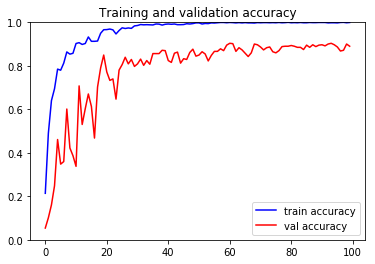

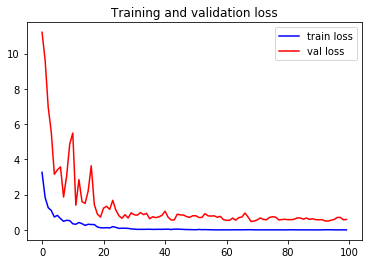

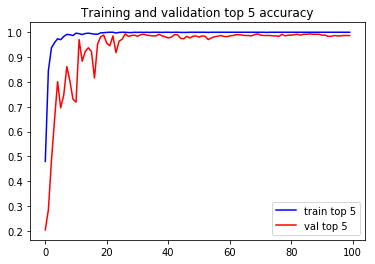

In [19]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  topk = history.history['top_k_categorical_accuracy']
  val_topk = history.history['val_top_k_categorical_accuracy']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'b', label='train accuracy')
  plt.plot(epochs, val_acc, 'r', label='val accuracy')
  plt.title('Training and validation accuracy')
  plt.ylim(0, 1)
  plt.legend()
  
  plt.figure()
  plt.plot(epochs, loss, 'b', label='train loss')
  plt.plot(epochs, val_loss, 'r', label='val loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  
  plt.figure()
  plt.plot(epochs, topk, 'b', label='train top 5')
  plt.plot(epochs, val_topk, 'r', label='val top 5')
  plt.title('Training and validation top 5 accuracy')
  plt.legend()
  plt.show()
  
plot_training(history)

In [0]:
model.save_weights('model_weights60_LR.h5')

### Test set performance

In [21]:
print(model.evaluate_generator(test_generator))
print(model.metrics_names)

[0.209590747786628, 0.94747084, 0.99610895]
['loss', 'acc', 'top_k_categorical_accuracy']


## Error analysis

### Confusion Matrix



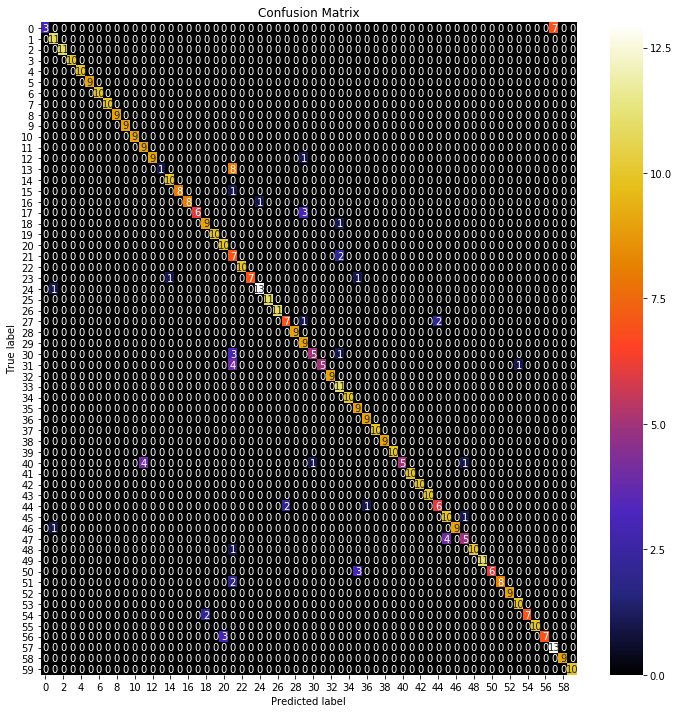

In [24]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

probabilities = model.predict_generator(validation_generator)
y_pred = np.argmax(probabilities, axis=1)
y_correct = validation_generator.classes

class_names = sorted([os.path.basename(os.path.dirname(f)) for f in glob('./processed/train/*/')])

cm = confusion_matrix(y_correct, y_pred)
cm_df = pd.DataFrame(cm,
                     index = [idx for idx in range(len(class_names))],
                     columns = [idx for idx in range(len(class_names))])

plt.figure(figsize=(12, 12))
sns.heatmap(cm_df, annot=True, cmap='CMRmap')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



### All errors list

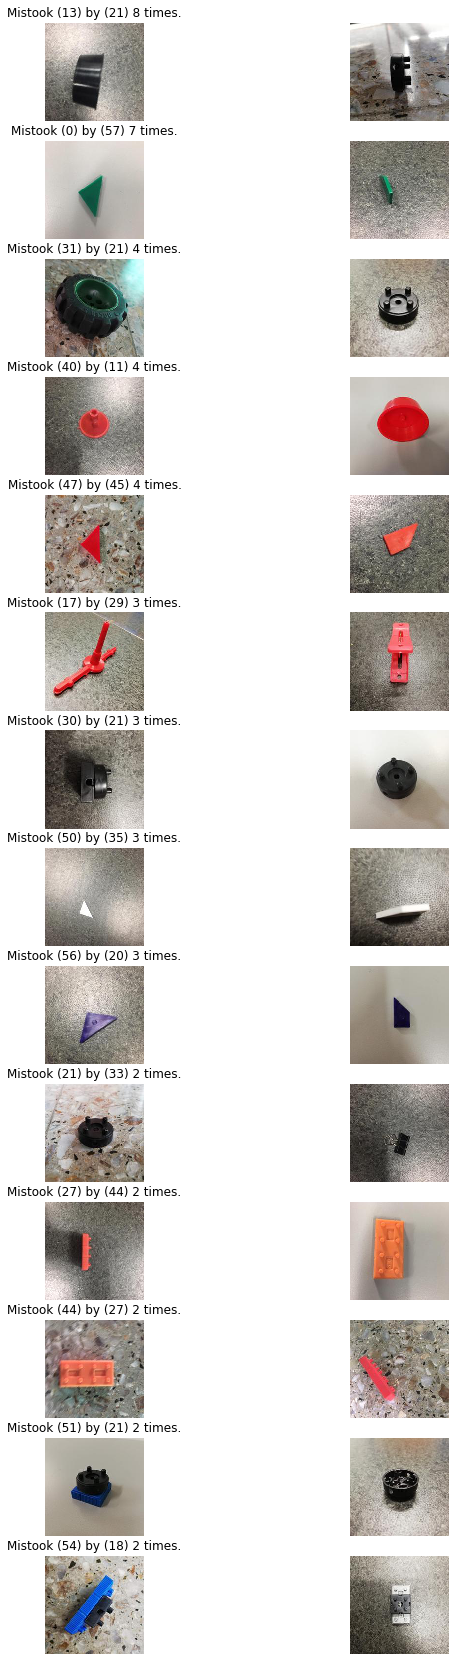

In [23]:
def sort_by_cm(pair):
  return cm[pair]


mistaken_pairs = [(i, j) for i,j in np.ndindex((len(cm), len(cm)))  if cm[i, j] > 1 and i != j]
mistaken_pairs.sort(key = sort_by_cm, reverse=True)
plt.figure(figsize=(10, 30))

for k, pair in enumerate(mistaken_pairs):
  class1_idx = pair[0]
  class2_idx = pair[1]

  class1_img = np.random.choice(glob('./processed/train/' + class_names[class1_idx] + '/*'))
  class1_img = PIL.Image.open(class1_img).convert('RGB')
  class1_img = np.asarray(class1_img)

  plt.subplot(len(mistaken_pairs), 2, 2*k+1)
  plt.title("Mistook ({0}) by ({1}) {2} times.".format(str(class1_idx), str(class2_idx), cm[pair]))
  plt.imshow(class1_img)
  plt.axis('off')

  class2_img = np.random.choice(glob('./processed/train/' + class_names[class2_idx] + '/*'))
  class2_img = PIL.Image.open(class2_img).convert('RGB')
  class2_img = np.asarray(class2_img)

  plt.subplot(len(mistaken_pairs), 2, 2*k+2)
  plt.imshow(class2_img)
  plt.axis('off')



### Examples of preditions

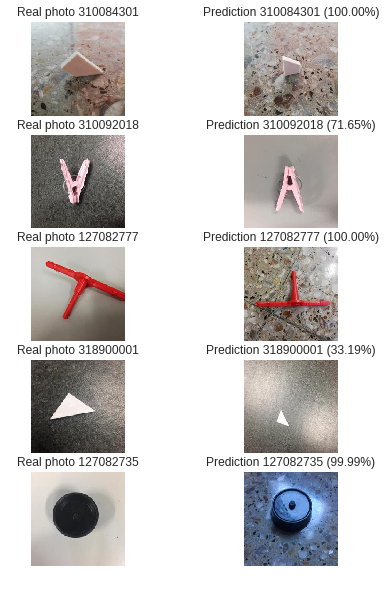

In [0]:
x_batch, y_batch = next(validation_generator)
x_batch = x_batch[:5]
y_batch = y_batch[:5]

class_names = sorted([os.path.basename(os.path.dirname(f)) for f in glob('./processed/train/*/')])

plt.figure(figsize=(7, 10))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
  correct_lbl = np.argmax(lbl)
  
  img_pre = np.expand_dims(img, axis=0)
  preds = model.predict(img_pre)
  predicted_lbl = np.argmax(preds)
  predicted_prob = np.max(preds)
  
  predicted_file = np.random.choice(glob('./processed/train/' + class_names[predicted_lbl] + '/*'))
  predicted_obj = PIL.Image.open(predicted_file).convert('RGB')
  predicted_arr = np.asarray(predicted_obj)
  
  plt.subplot(5, 2, 2*k+1)
  plt.title('Real photo ' + class_names[correct_lbl])
  plt.imshow((img + 1) / 2)
  plt.axis('off')
  
  plt.subplot(5, 2, 2*k+2)
  plt.title('Prediction {} ({:.2f}%)'.format(class_names[predicted_lbl], predicted_prob*100))
  plt.imshow(predicted_arr)
  plt.axis('off')

22 310094037
310094037 310094037 0.9936599


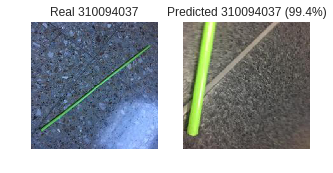

11 304600147
304600147 304600147 1.0


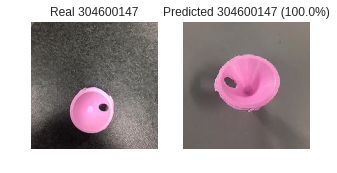

20 310084700
310095043 310084700 0.99999344


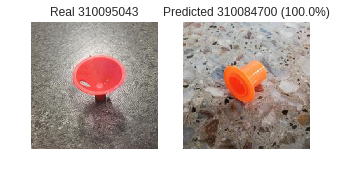

3 127082727
127082727 127082727 0.9794948


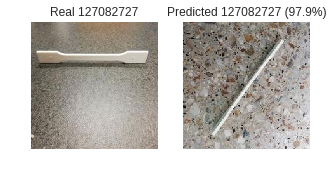

18 310080818
310080818 310080818 0.9998598


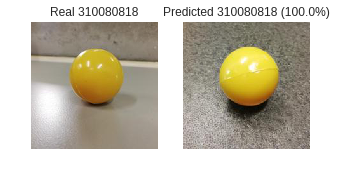

18 310080818
310080818 310080818 0.99999607


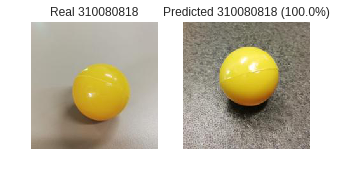

6 127082745
127082745 127082745 0.9999862


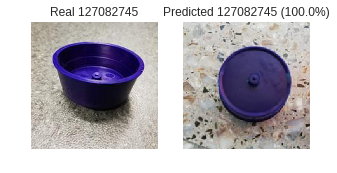

5 127082735
127082735 127082735 0.9997464


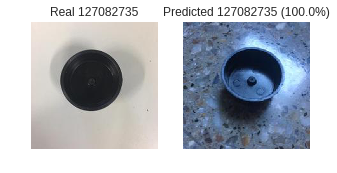

11 304600147
304600147 304600147 0.9999958


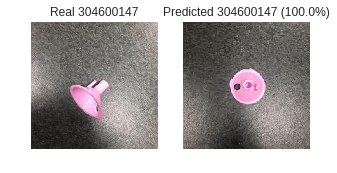

29 340311026
340311026 340311026 0.9584609


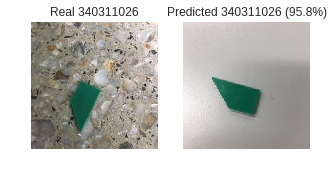

In [0]:
import PIL
show_N = 10

class_names = sorted([os.path.basename(os.path.dirname(f)) for f in glob('./processed/train/*/')])
show_test_files = np.random.choice(test_files, show_N)

for filepath in show_test_files:
    im_obj = PIL.Image.open(filepath).resize((256, 256), PIL.Image.ANTIALIAS)
    im_obj = im_obj.convert('RGB')
    im_arr = np.asarray(im_obj)
    im_arr_dims = np.expand_dims(im_arr, axis=0)
    im_arr_dims = preprocess_input(im_arr_dims)
    im_lbl = os.path.basename(os.path.dirname(filepath))
    
    preds = model.predict(im_arr_dims)
    predicted_index = np.argmax(preds)
    predicted_lbl = class_names[predicted_index]
    predicted_prob = np.max(preds)
    print(predicted_index, predicted_lbl)
    predicted_file = np.random.choice(glob('./processed/train/' + predicted_lbl + '/*'))
    predicted_obj = PIL.Image.open(predicted_file).convert('RGB')
    predicted_arr = np.asarray(predicted_obj)

    print(im_lbl, predicted_lbl, predicted_prob)

  
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title('Real {}'.format(im_lbl))
    plt.imshow(im_arr)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title('Predicted {} ({:.1f}%)'.format(predicted_lbl, predicted_prob*100))
    plt.imshow(predicted_arr)
    
    plt.show()